<a href="https://colab.research.google.com/github/LuluW8071/Conformer/blob/main/notebooks/Conformer_Inference_With_CTC_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformer ASR Inference With CTC Decoder

Performing speech recognition inference using a CTC Beam Search Decoder with lexicon constrain and KenLM lanagauge model support.

## Overview

Beam search decoding works by iteratively expanding text hypotheses (beams) with next possible characters, and maintaining only the hypotheses with the highest scores at each time step. A language model can be incorporated into the scoring computation, and adding a lexicon constraint restricts the next possible tokens for the hypotheses so that only words from the lexicon can be generated.

Running ASR inference using a CTC Beam Search decoder with a language model and lexicon constraint requires the following components

- __Acoustic Model:__ model predicting phonetics from audio waveforms

- __Tokens:__ the possible predicted tokens from the acoustic model

- __Lexicon:__ mapping between possible words and their corresponding tokens sequence

- __Language Model (LM):__ n-gram language model trained with the KenLM library, or custom language model that inherits CTCDecoderLM

## Acoustic Model and Set Up

I have trained two conformer models.
- One is on Mozilla Corpus and my personal recordings
- And another is on LibriSpeech ASR corpus.

In [1]:
!pip install flashlight-text --quiet

In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.5.1+cu124
2.5.1+cu124


In [2]:
import time
from typing import List

import IPython
import matplotlib.pyplot as plt
from torchaudio.models.decoder import ctc_decoder
from torchaudio.utils import download_asset

In [4]:
# Downloading the trained model
!gdown https://drive.google.com/file/d/1XcouMWSncUeNBvGZednuWYK1jdfKisCr/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1b_ElF1ihnI1H4dTlGzAQQJZzgOt0jqiv/view?usp=sharing --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1XcouMWSncUeNBvGZednuWYK1jdfKisCr
From (redirected): https://drive.google.com/uc?id=1XcouMWSncUeNBvGZednuWYK1jdfKisCr&confirm=t&uuid=a169e195-3f44-4d97-bee9-011cbcc0fc11
To: /teamspace/studios/this_studio/Conformer/notebooks/Conformer(LibriSpeech)-epoch=24-val_wer=0.23.ckpt
100%|████████████████████████████████████████| 118M/118M [00:01<00:00, 95.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1b_ElF1ihnI1H4dTlGzAQQJZzgOt0jqiv
From (redirected): https://drive.google.com/uc?id=1b_ElF1ihnI1H4dTlGzAQQJZzgOt0jqiv&confirm=t&uuid=80d625c5-da10-4cf3-a829-c5bbf6d260f9
To: /teamspace/studios/this_studio/Conformer/notebooks/Conformer(Mozilla_corpus)_val_wer=0.253.ckpt
100%|████████████████████████████████████████| 118M/118M [00:01<00:00, 60.7MB/s]


In [ ]:
!git clone https://github.com/LuluW8071/Conformer.git

In [6]:
!python3 ../torchscript.py --model_checkpoint "Conformer(Mozilla_corpus)_val_wer=0.253.ckpt" --save_path "mozilla_model/"
!python3 ../torchscript.py --model_checkpoint "Conformer(LibriSpeech)-epoch=24-val_wer=0.23.ckpt" --save_path "libri_model/"

Loading model from Conformer(Mozilla_corpus)_val_wer=0.253.ckpt
Tracing model...
Saving to mozilla_model/
Done!
Loading model from Conformer(LibriSpeech)-epoch=24-val_wer=0.23.ckpt
Tracing model...
Saving to libri_model/
Done!


In [3]:
# Load the optimized Torchscipt model for inference
mozilla_model_poth = "mozilla_model/optimized_model.pt"
libri_model_path = "libri_model/optimized_model.pt"

mozilla = torch.jit.load(mozilla_model_poth)
libri = torch.jit.load(libri_model_path)

In [4]:
# Set to eval mode
libri.eval().to("cpu")
mozilla.eval().to("cpu")

RecursiveScriptModule(
  original_name=ConformerASR
  (encoder): RecursiveScriptModule(
    original_name=ConformerEncoder
    (conv_subsample): RecursiveScriptModule(
      original_name=Conv2dSubsampling
      (module): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=ReLU)
        (2): RecursiveScriptModule(original_name=Conv2d)
        (3): RecursiveScriptModule(original_name=ReLU)
      )
    )
    (linear_proj): RecursiveScriptModule(original_name=Linear)
    (dropout): RecursiveScriptModule(original_name=Dropout)
    (layers): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=ConformerBlock
        (ff1): RecursiveScriptModule(
          original_name=FeedForwardBlock
          (module): RecursiveScriptModule(
            original_name=Sequential
            (0): RecursiveScriptModule(original_name=LayerNorm)

In [5]:
# Load a sample from the LibriSpeech test-other dataset.
speech_file = download_asset("tutorial-assets/ctc-decoding/1688-142285-0007.wav")
IPython.display.Audio(speech_file)

The transcript corresponds to:

```
i really was very much afraid of showing him how much shocked i was at some parts of what he said
```

## Files and Data for Decoder

Next, we load in our token, lexicon, and language model data, which are used by the decoder to predict words from the acoustic model output. Pretrained files for the LibriSpeech dataset can be downloaded through torchaudio, or the user can provide their own files.

### 1. Tokens
The tokens are the possible symbols that the acoustic model can predict, including the blank and silent symbols. It can either be passed in as a file, where each line consists of the tokens corresponding to the same index, or as a list of tokens, each mapping to a unique index.

In [6]:
%%writefile tokens.txt
'
|
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
-

Overwriting tokens.txt


In [7]:
token_file_path = 'tokens.txt'

with open(token_file_path, 'r') as file:
    tokens = file.read().splitlines()

## 2. Lexicon

The lexicon is a mapping from words to their corresponding tokens sequence, and is used to restrict the search space of the decoder to only words from the lexicon. The expected format of the lexicon file is a line per word, with a word followed by its space-split tokens.

## 3. Language Model

A language model can be used in decoding to improve the results, by factoring in a language model score that represents the likelihood of the sequence into the beam search computation.

In [8]:
from torchaudio.models.decoder import download_pretrained_files

# Download pre trained Ken Language Model
files = download_pretrained_files("librispeech-4-gram")
print(files)

PretrainedFiles(lexicon='/home/zeus/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lexicon.txt', tokens='/home/zeus/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/tokens.txt', lm='/home/zeus/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lm.bin')


## Construct Greedy Decoder

In [9]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> List[str]:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]

        # Join the decoded indices into a string and replace "-" and "|" with spaces
        joined = "".join([self.labels[i] for i in indices])
        return joined.replace("-", " ").replace("|", " ").strip().split()

greedy_decoder = GreedyCTCDecoder(tokens)

## Run Inference

In [10]:
from Conformer.dataset import get_featurizer

waveform, _ = torchaudio.load(speech_file)
waveform_tensor = waveform[0]

waveform = get_featurizer()(waveform)
print(waveform.shape)

waveform = waveform.permute(0, 2, 1)
print(waveform.shape)

torch.Size([1, 80, 707])
torch.Size([1, 707, 80])


In [11]:
import torch.nn.functional as F

original_transcript = "i really was very much afraid of showing him how much shocked i was at some parts of what he said"
actual_transcript = original_transcript.split()

# Pass the audio inputs to model
libri_emission = libri(waveform)
mozilla_emission = mozilla(waveform)

In [12]:
class Color:
    YELLOW = '\033[33m'
    CYAN = '\033[36m'
    GREEN = '\033[32m'
    RESET = '\033[0m'

In [13]:
# Greedy Decoding
greedy_libri_result = greedy_decoder(libri_emission[0])
greedy_mozilla_result = greedy_decoder(mozilla_emission[0])

greedy_transcript = " ".join(greedy_libri_result)
greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_libri_result) / len(actual_transcript)
print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
print(f"{Color.CYAN}Transcript: {greedy_transcript}{Color.RESET}")
print(f"{Color.GREEN}WER: {round(greedy_wer, 4)}{Color.RESET}\n")

greedy_transcript = " ".join(greedy_mozilla_result)
greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_mozilla_result) / len(actual_transcript)
print(f"{Color.CYAN}Transcript: {greedy_transcript}{Color.RESET}")
print(f"{Color.GREEN}WER: {round(greedy_wer, 4)}{Color.RESET}\n")

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i real ly was very much a fraid of showing him how much sh oc ed i was t at some part of what he said
WER: 0.4286

Transcript: i real ly was very much af frai d of show ing him ham ma shoc t er was at some p art of what he said
WER: 0.6667



> `42.86%` & `66.67%` word error is pretty bad on __greedy decoding__.
> Let's try on __CTC Beam Search Decoding__ and then __Beam Search with Language Model__. 😀

## Construct Beam Search Decoder

In [14]:
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=None,
    nbest=3,
    beam_size=10,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [15]:
def beam_search(emission):    
    beam_search_result = beam_search_decoder(emission)
    beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
        actual_transcript
    )

    print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
    print(f"{Color.CYAN}Transcript: {beam_search_transcript}{Color.RESET}")
    print(f"{Color.GREEN}WER: {round(beam_search_wer, 4)}{Color.RESET}")

    return beam_search_result

In [20]:
beam_search_result = beam_search(libri_emission)

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was very much afraid of showing him how much shocked i was tat some part of what he said
WER: 0.0952


In [21]:
mozilla_output = beam_search(mozilla_emission)

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was very much af fraid of showing him hamma shote was at some part of what he said
WER: 0.3333


> Achieved `42.86%` & `66.67%` **WER** with **greedy decoding**. After switching to **CTC Beam Search without LM**, we improved significantly, lowering the WER to `9.52%` and `33.33%`. 🚀

## CTC Decoder + KenLM

In [16]:
beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=files.lm,
    nbest=3,
    beam_size=10,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [23]:
beam_search_result = beam_search(libri_emission)

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was very much afraid of showing him how much shocked i was at some part of what he said
WER: 0.0476


In [24]:
mozilla_output = beam_search(mozilla_emission)

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was very much afraid of showing him she was at some part of what he said
WER: 0.2381


> Even more impressive, adding a **language model** (LM) brought the WER down to an outstanding `4.76%` and `23.81%`! 💥
> This demonstrates the true power of integrating an LM for more accurate and context-aware predictions! 📈🔥

# Timestep Alignments

Visualize the token timestep alignments relative to the original waveform.

In [25]:
timesteps = beam_search_result[0][0].timesteps
predicted_tokens = beam_search_decoder.idxs_to_tokens(beam_search_result[0][0].tokens)

print(predicted_tokens, len(predicted_tokens))
print(timesteps, timesteps.shape[0])

['|', 'i', '|', 'r', 'e', 'a', 'l', 'l', 'y', '|', 'w', 'a', 's', '|', 'v', 'e', 'r', 'y', '|', 'm', 'u', 'c', 'h', '|', 'a', 'f', 'r', 'a', 'i', 'd', '|', 'o', 'f', '|', 's', 'h', 'o', 'w', 'i', 'n', 'g', '|', 'h', 'i', 'm', '|', 'h', 'o', 'w', '|', 'm', 'u', 'c', 'h', '|', 's', 'h', 'o', 'c', 'k', 'e', 'd', '|', 'i', '|', 'w', 'a', 's', '|', 'a', 't', '|', 's', 'o', 'm', 'e', '|', 'p', 'a', 'r', 't', '|', 'o', 'f', '|', 'w', 'h', 'a', 't', '|', 'h', 'e', '|', 's', 'a', 'i', 'd', '|', '|'] 99
tensor([  0,  13,  15,  17,  19,  20,  21,  23,  25,  26,  27,  28,  29,  31,
         34,  36,  37,  39,  40,  42,  43,  44,  45,  47,  49,  51,  53,  54,
         55,  57,  64,  67,  68,  69,  71,  72,  73,  74,  76,  77,  79,  80,
         81,  82,  83,  84,  87,  88,  89,  90,  92,  93,  94,  95,  97,  98,
         99, 101, 102, 103, 104, 105, 107, 108, 111, 113, 114, 115, 121, 126,
        127, 128, 130, 131, 132, 133, 135, 136, 138, 139, 141, 143, 146, 147,
        148, 150, 151, 152, 153, 

In [26]:
def plot_alignments(waveform, emission, tokens, timesteps, sample_rate):
    # Calculate time and ratio
    t = torch.arange(waveform.size(0)) / sample_rate
    ratio = waveform.size(0) / emission.size(1) / sample_rate

    # Create alignment data
    chars = []
    words = []
    word_start = None
    for token, timestep in zip(tokens, timesteps * ratio):
        if token == "|":
            if word_start is not None:
                words.append((word_start, timestep))
            word_start = None
        else:
            chars.append((token, timestep))
            if word_start is None:
                word_start = timestep

    # Create figure and subplots with higher resolution
    fig, axes = plt.subplots(3, 1, figsize=(12, 6), dpi=150)

    def _plot(ax, xlim):
        # Plot waveform
        ax.plot(t, waveform, linewidth=1.0, alpha=0.9)
        # Annotate tokens
        for token, timestep in chars:
            ax.annotate(
                token.upper(),
                (timestep, 0.5),
                fontsize=8,
                color="black",
                ha="center",
                va="bottom"
            )

        # Highlight word spans
        for word_start, word_end in words:
            ax.axvspan(word_start, word_end, alpha=0.2, color="red")
        # Configure plot aesthetics
        ax.set_ylim(-0.6, 0.7)
        ax.set_yticks([0])
        ax.grid(True, axis="y", linestyle="--", alpha=0.5)
        ax.set_xlim(xlim)

    # Plot each segment
    _plot(axes[0], (0.3, 2.5))
    _plot(axes[1], (2.5, 4.7))
    _plot(axes[2], (4.7, 6.9))

    # Add shared x-axis label and adjust layout
    axes[2].set_xlabel("Time (seconds)", fontsize=12)
    fig.tight_layout(pad=2.0)

    plt.show()

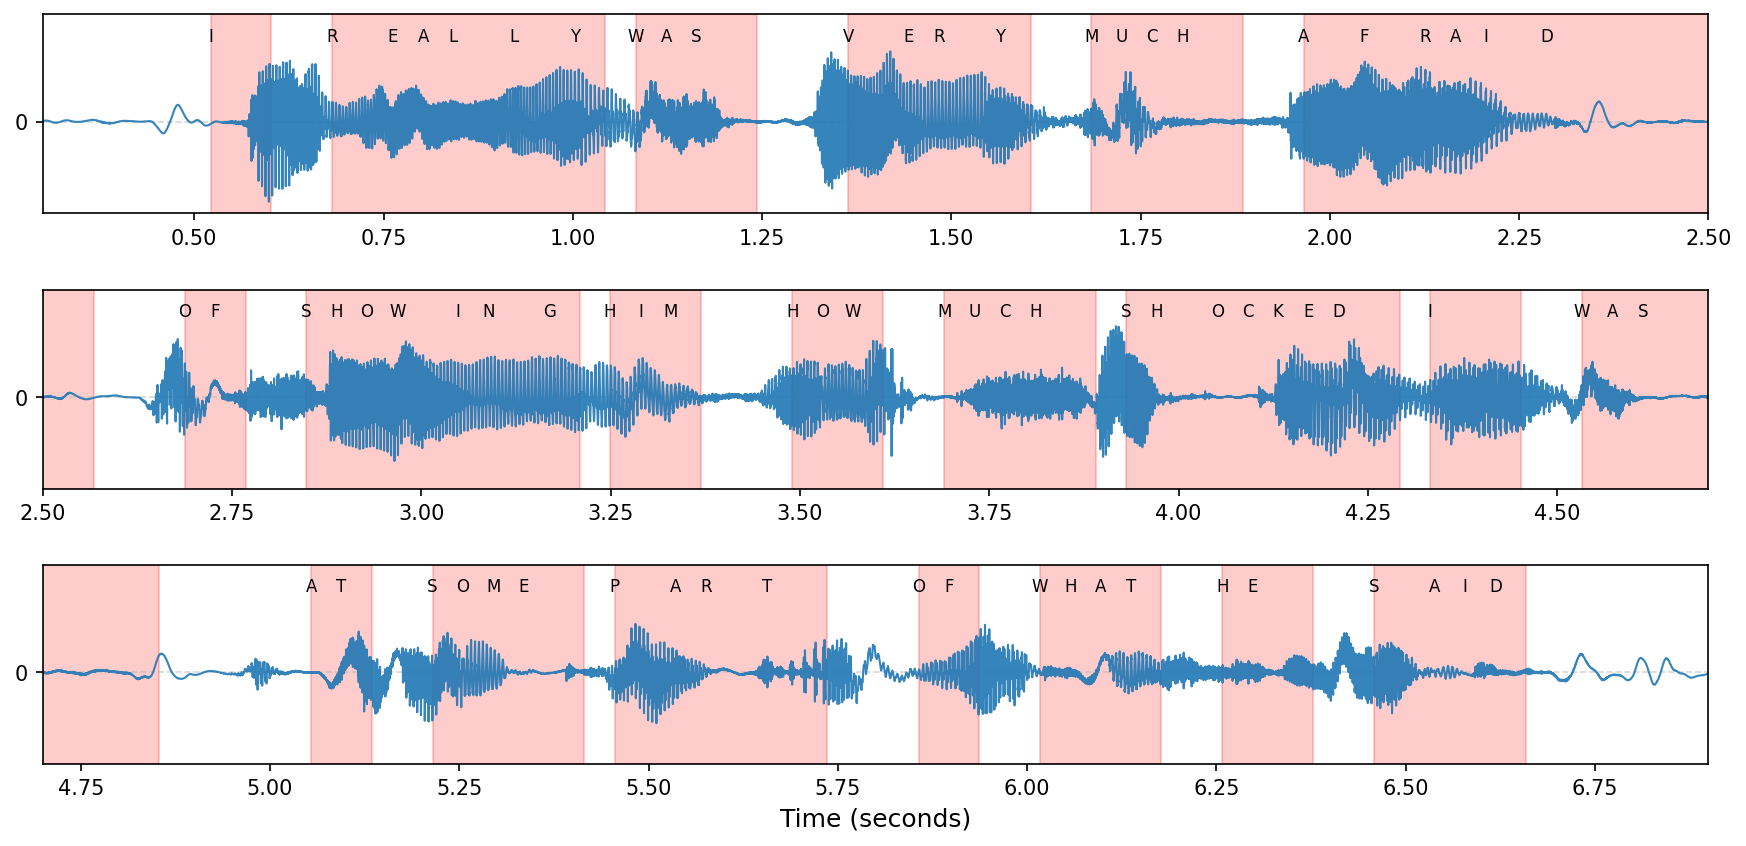

In [27]:
plot_alignments(waveform_tensor, libri_emission, predicted_tokens, timesteps, 16000)

## Beam Search with Decoder Parameters

In [20]:
def print_decoded(decoder, emission, actual_transcript, param, param_value):
    start_time = time.monotonic()
    result = decoder(emission)
    decode_time = time.monotonic() - start_time

    transcript = " ".join(result[0][0].words).lower().strip()
    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, result[0][0].words) / len(
        actual_transcript
    )

    score = result[0][0].score
    print(f"{param} {param_value:<3}: {transcript} (score: {score:.2f}; {decode_time:.4f} secs; WER: {beam_search_wer:.3f})")

In [29]:
beam_search_result

[[CTCHypothesis(tokens=tensor([ 1, 10,  1, 19,  6,  2, 13, 13, 26,  1, 24,  2, 20,  1, 23,  6, 19, 26,
           1, 14, 22,  4,  9,  1,  2,  7, 19,  2, 10,  5,  1, 16,  7,  1, 20,  9,
          16, 24, 10, 15,  8,  1,  9, 10, 14,  1,  9, 16, 24,  1, 14, 22,  4,  9,
           1, 20,  9, 16,  4, 12,  6,  5,  1, 10,  1, 24,  2, 20,  1,  2, 21,  1,
          20, 16, 14,  6,  1, 17,  2, 19, 21,  1, 16,  7,  1, 24,  9,  2, 21,  1,
           9,  6,  1, 20,  2, 10,  5,  1,  1]), words=['i', 'really', 'was', 'very', 'much', 'afraid', 'of', 'showing', 'him', 'how', 'much', 'shocked', 'i', 'was', 'at', 'some', 'part', 'of', 'what', 'he', 'said'], score=1772.6455159473421, timesteps=tensor([  0,  13,  15,  17,  19,  20,  21,  23,  25,  26,  27,  28,  29,  31,
           34,  36,  37,  39,  40,  42,  43,  44,  45,  47,  49,  51,  53,  54,
           55,  57,  64,  67,  68,  69,  71,  72,  73,  74,  76,  77,  79,  80,
           81,  82,  83,  84,  87,  88,  89,  90,  92,  93,  94,  95,  97,  98,

In [30]:
for i in range(2):
    transcript = " ".join(beam_search_result[0][i].words).strip()
    score = beam_search_result[0][i].score
    print(f"{transcript} (score: {score:.3f})")

i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 1772.646)
i really was very much afraid of showing him how much she was at some part of what he said (score: 1772.156)


### Beam Size

The `beam_size` parameter determines the maximum number of best hypotheses to hold after each decoding step. Using larger beam sizes allows for exploring a larger range of possible hypotheses which can produce hypotheses with higher scores, but it is computationally more expensive and does not provide additional gains beyond a certain point.

In the example below, we see improvement in decoding quality as we increase beam size from 1 to 5 to 50, but notice how using a beam size of 500 provides the same output as beam size 50 while increase the computation time.

In [31]:
beam_sizes = [1, 5, 50, 500]

for beam_size in beam_sizes:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=tokens,
        lm=files.lm,
        beam_size=beam_size,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )
    print_decoded(beam_search_decoder, libri_emission, actual_transcript, "beam size", beam_size)
    del beam_search_decoder

beam size 1  : i ease much afraid of she him howe at some at of what he (score: 1452.43; 0.0311 secs; WER: 0.524)
beam size 5  : i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 1772.65; 0.0970 secs; WER: 0.048)
beam size 50 : i really was very much afraid of showing him how much shocked was that some part of what he said (score: 1773.16; 0.2110 secs; WER: 0.143)
beam size 500: i really was very much afraid of showing him how much shocked was that some part of what he said (score: 1773.16; 0.4307 secs; WER: 0.143)


In [32]:
for beam_size in beam_sizes:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=tokens,
        lm=files.lm,
        beam_size=beam_size,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )
    print_decoded(beam_search_decoder, mozilla_emission, actual_transcript, "beam size", beam_size)
    del beam_search_decoder

beam size 1  : i (score: 1001.23; 0.0227 secs; WER: 0.952)
beam size 5  : i really was very much afraid of showing him a she was at some part of what he said (score: 1457.71; 0.0604 secs; WER: 0.238)
beam size 50 : i really was very much afraid of showing him how she was at some part of what he said (score: 1466.82; 0.2714 secs; WER: 0.190)
beam size 500: i really was very much afraid of showing him that she was at some part of what he said (score: 1469.62; 0.5332 secs; WER: 0.238)


### Beam Size Token

The `beam_size_token` parameter corresponds to the number of tokens to consider for expanding each hypothesis at the decoding step. Exploring a larger number of next possible tokens increases the range of potential hypotheses at the cost of computation.

In [33]:
num_tokens = len(tokens)
beam_size_tokens = [1, 5, 10, num_tokens]

for beam_size_token in beam_size_tokens:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=tokens,
        lm=files.lm,
        beam_size_token=beam_size_token,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, libri_emission, actual_transcript, "beam size token", beam_size_token)
    del beam_search_decoder

beam size token 1  : i really was very much afraid of showing him how much she was at some part of what he (score: 1765.17; 0.2599 secs; WER: 0.190)
beam size token 5  : i really was very much afraid of showing him how much shocked was that some part of what he said (score: 1773.16; 0.2789 secs; WER: 0.143)
beam size token 10 : i really was very much afraid of showing him how much shocked was that some part of what he said (score: 1773.16; 0.2837 secs; WER: 0.143)
beam size token 29 : i really was very much afraid of showing him how much shocked was that some part of what he said (score: 1773.16; 0.3307 secs; WER: 0.143)


In [34]:
for beam_size_token in beam_size_tokens:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=tokens,
        lm=files.lm,
        beam_size_token=beam_size_token,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, mozilla_emission, actual_transcript, "beam size token", beam_size_token)
    del beam_search_decoder

beam size token 1  : i really was very much afraid of showing him she was at some part of what he (score: 1453.93; 0.2941 secs; WER: 0.286)
beam size token 5  : i really was very much afraid of showing him how she was at some part of what he said (score: 1466.82; 0.2960 secs; WER: 0.190)
beam size token 10 : i really was very much afraid of showing him she was at some part of what he said (score: 1465.96; 0.3328 secs; WER: 0.238)
beam size token 29 : i really was very much afraid of showing him how she was at some part of what he said (score: 1466.82; 0.3253 secs; WER: 0.190)


### Beam Threshold

The `beam_threshold` parameter is used to prune the stored hypotheses set at each decoding step, removing hypotheses whose scores are greater than `beam_threshold` away from the highest scoring hypothesis. There is a balance between choosing smaller thresholds to prune more hypotheses and reduce the search space, and choosing a large enough threshold such that plausible hypotheses are not pruned.

In [35]:
beam_thresholds = [1, 5, 10, 25]

for beam_threshold in beam_thresholds:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=tokens,
        lm=files.lm,
        beam_threshold=beam_threshold,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, libri_emission, actual_transcript, "beam threshold", beam_threshold)
    del beam_search_decoder

beam threshold 1  : i ease much afraid of she him how shocked i was at some at of what he (score: 1522.46; 0.0347 secs; WER: 0.333)
beam threshold 5  : i ally was very much afraid of showing him how much shocked was that some part of what he (score: 1732.01; 0.1453 secs; WER: 0.238)
beam threshold 10 : i really was very much afraid of showing him how much shocked was that some part of what he said (score: 1773.16; 0.3046 secs; WER: 0.143)
beam threshold 25 : i really was very much afraid of showing him how much shocked was that some part of what he said (score: 1773.16; 0.3296 secs; WER: 0.143)


In [36]:
for beam_threshold in beam_thresholds:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=tokens,
        lm=files.lm,
        beam_threshold=beam_threshold,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, mozilla_emission, actual_transcript, "beam threshold", beam_threshold)
    del beam_search_decoder

beam threshold 1  : i allas much after she him she was at some part of what he said (score: 1321.38; 0.0275 secs; WER: 0.524)
beam threshold 5  : all was much afraid of showing him she was at some part of what he said (score: 1418.74; 0.1260 secs; WER: 0.381)
beam threshold 10 : i really was very much afraid of showing him how she was at some part of what he said (score: 1466.82; 0.3316 secs; WER: 0.190)
beam threshold 25 : i really was very much afraid of showing him how she was at some part of what he said (score: 1466.82; 0.3329 secs; WER: 0.190)


### Language Model Weight

The `lm_weight` parameter is the weight to assign to the language model score which to accumulate with the acoustic model score for determining the overall scores. Larger weights encourage the model to predict next words based on the language model, while smaller weights give more weight to the acoustic model score instead.

In [37]:
lm_weights = [0, LM_WEIGHT, 15]

for lm_weight in lm_weights:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=tokens,
        lm=files.lm,
        lm_weight=lm_weight,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, libri_emission, actual_transcript, "lm weight", lm_weight)
    del beam_search_decoder

lm weight 0  : i really was very much afraid of showing him how much shocked i was tat some part of what he said (score: 1891.25; 0.3322 secs; WER: 0.095)
lm weight 3.23: i really was very much afraid of showing him how much shocked was that some part of what he said (score: 1773.16; 0.3330 secs; WER: 0.143)
lm weight 15 : and then he said (score: 1238.70; 0.3310 secs; WER: 0.905)


In [38]:
for lm_weight in lm_weights:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=tokens,
        lm=files.lm,
        lm_weight=lm_weight,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, mozilla_emission, actual_transcript, "lm weight", lm_weight)
    del beam_search_decoder

lm weight 0  : i really was very much af fraid of showing him hamma shoer was at some part of what he said (score: 1586.63; 0.3338 secs; WER: 0.333)
lm weight 3.23: i really was very much afraid of showing him how she was at some part of what he said (score: 1466.82; 0.3557 secs; WER: 0.190)
lm weight 15 : what (score: 1053.43; 0.3279 secs; WER: 0.952)


In [30]:
def print_decoded(decoder, emission, actual_transcript, **kwargs):
    start_time = time.monotonic()
    result = decoder(emission)
    decode_time = time.monotonic() - start_time

    transcript = " ".join(result[0][0].words).lower().strip()
    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, result[0][0].words) / len(actual_transcript)

    score = result[0][0].score
    param_str = " | ".join([f"{key}: {value}" for key, value in kwargs.items()])
    print(f"{param_str} => (score: {score:.2f}; {decode_time:.4f} secs; WER: {beam_search_wer:.3f})")

In [43]:
# Hyperparameters
beam_threshold = 10
beam_sizes = [5, 10, 50]
beam_size_token = 5 
n_best = [1, 5, 10]

# Looping through all combinations of parameters
for n in n_best:
    for beam_size in beam_sizes:
        # Initialize the decoder with current parameters
        beam_search_decoder = ctc_decoder(
            lexicon=files.lexicon,
            tokens=tokens,
            lm=files.lm,
            nbest=n,
            lm_weight=3.23,
            word_score=-0.26,
            beam_size=beam_size,
            beam_threshold=beam_threshold,
            beam_size_token=beam_size_token
        )

        # Decoding and printing the result for the current combination
        print_decoded(beam_search_decoder, mozilla_emission, actual_transcript, 
                n_best=n,
                beam_size=beam_size
        )

        # Clean up the decoder after use
        del beam_search_decoder

n_best: 1 | beam_size: 5 => (score: 1457.71; 0.0622 secs; WER: 0.238)
n_best: 1 | beam_size: 10 => (score: 1465.96; 0.0551 secs; WER: 0.238)
n_best: 1 | beam_size: 50 => (score: 1466.82; 0.0577 secs; WER: 0.190)
n_best: 5 | beam_size: 5 => (score: 1457.71; 0.0549 secs; WER: 0.238)
n_best: 5 | beam_size: 10 => (score: 1465.96; 0.0552 secs; WER: 0.238)
n_best: 5 | beam_size: 50 => (score: 1466.82; 0.0569 secs; WER: 0.190)
n_best: 10 | beam_size: 5 => (score: 1457.71; 0.0551 secs; WER: 0.238)
n_best: 10 | beam_size: 10 => (score: 1465.96; 0.0577 secs; WER: 0.238)
n_best: 10 | beam_size: 50 => (score: 1466.82; 0.0565 secs; WER: 0.190)


## Comparative Analysis

| Method                          | LibriSpeech WER    | Mozilla WER |
|----------------------------------|--------|-------------|
| **Greedy Decoding**            | 42.86% | 66.67% |
| **CTC Beam Search (without LM)** | __9.52%__  | __33.33%__ |
| **CTC Beam Search (with LM)**    | __4.76%__  | __23.81%__ |
| **Tuned CTC Beam Search (with LM)**    | - | __19.00%__ |

# Additional Parameters

Additional parameters that can be optimized include the following

- `word_score`: score to add when word finishes

- `unk_score`: unknown word appearance score to add

- `sil_score`: silence appearance score to add

- `log_add`: whether to use log add for lexicon Trie smearing

In [18]:
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=files.lm,
    nbest=3,
    beam_size=5,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [17]:
# Load a sample from the LibriSpeech test-other dataset.
speech_file = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
IPython.display.Audio(speech_file)

In [18]:
waveform, _ = torchaudio.load(speech_file)

waveform = get_featurizer()(waveform)
waveform = waveform.permute(0, 2, 1)
print(waveform.shape)

torch.Size([1, 341, 80])


In [19]:
original_transcript = "i had that curiosity beside me at this moment"
actual_transcript = original_transcript.split()

# Pass the audio inputs to model
libri_emission = libri(waveform)
mozilla_emission = mozilla(waveform)

In [23]:
beam_search_result = beam_search(libri_emission)

Orig_trans: i had that curiosity beside me at this moment
Transcript: i had that curiosity beside me at this moment
WER: 0.0


In [24]:
beam_search_result = beam_search(mozilla_emission)

Orig_trans: i had that curiosity beside me at this moment
Transcript: i had that curiosity beside me at this moment
WER: 0.0


## Conclusion 🚀
By switching to __Beam Search with a Language Model__, we observed a significant reduction in WER. Additionally, by tuning beam search parameters such as `nbest`, `beam_size`, `Word Weight`, and `Language Model Weight`, we can improve even better but at the cost of computational speed. ⚡📉